# DRILL: Third Attempt

So here's your task. Get rid of as much data as possible without dropping below an average of 90% accuracy in a 10-fold cross validation.

You'll want to do a few things in this process. First, dive into the data that we have and see which features are most important. This can be the raw features or the generated dummies. You may want to use PCA or correlation matrices.

Can you do it without using anything related to payment amount or outstanding principal? How do you know?

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

In [4]:
lc_df = pd.read_csv('LoanStats3d.csv', skipinitialspace=True, header=1)

In [5]:
lc_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401,72868139.0,16000.0,16000.0,16000.0,60 months,14.85%,379.39,C,C5,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783,73244544.0,9600.0,9600.0,9600.0,36 months,7.49%,298.58,A,A4,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916,73356753.0,25000.0,25000.0,25000.0,36 months,7.49%,777.55,A,A4,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961,73356799.0,28000.0,28000.0,28000.0,36 months,6.49%,858.05,A,A2,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092,73384866.0,8650.0,8650.0,8650.0,36 months,19.89%,320.99,E,E3,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


In [6]:
lc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421097 entries, 0 to 421096
Columns: 111 entries, id to total_il_high_credit_limit
dtypes: float64(85), object(26)
memory usage: 356.6+ MB


In [7]:
print(lc_df.columns)

Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'term', 'int_rate', 'installment', 'grade', 'sub_grade',
       ...
       'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 'pct_tl_nvr_dlq',
       'percent_bc_gt_75', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
       'total_il_high_credit_limit'],
      dtype='object', length=111)


In [8]:
#categorical variables 

cat = lc_df.select_dtypes(['object']).columns

print(cat)
print(len(cat))

Index(['id', 'term', 'int_rate', 'grade', 'sub_grade', 'emp_title',
       'emp_length', 'home_ownership', 'verification_status', 'issue_d',
       'loan_status', 'pymnt_plan', 'url', 'desc', 'purpose', 'title',
       'zip_code', 'addr_state', 'earliest_cr_line', 'revol_util',
       'initial_list_status', 'last_pymnt_d', 'next_pymnt_d',
       'last_credit_pull_d', 'application_type', 'verification_status_joint'],
      dtype='object')
26


In [9]:
#numeric variables 

num = lc_df.select_dtypes(['int64', 'float64']).columns

print(num)
print(len(num))

Index(['member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'out_prncp', 'out_prncp_inv',
       'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp', 'total_rec_int',
       'total_rec_late_fee', 'recoveries', 'collection_recovery_fee',
       'last_pymnt_amnt', 'collections_12_mths_ex_med',
       'mths_since_last_major_derog', 'policy_code', 'annual_inc_joint',
       'dti_joint', 'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal',
       'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m',
       'mths_since_rcnt_il', 'total_bal_il', 'il_util', 'open_rv_12m',
       'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi',
       'total_cu_tl', 'inq_last_12m', 'acc_open_past_24mths', 'avg_cur_bal',
       'bc_open_to_buy', 'bc_util', 'chargeoff_within_12_mths', 'delinq_amn

In [10]:
#convert id and interest rate to numeric 

lc_df['id'] = pd.to_numeric(lc_df['id'], errors='coerce')
lc_df['int_rate'] = pd.to_numeric(lc_df['int_rate'].astype(str).str.strip('%'), errors='coerce')

#drop other columns with many unique variables
lc_df.drop(['url', 'zip_code', 'earliest_cr_line', 'revol_util',
         'sub_grade', 'addr_state', 'last_pymnt_d', 'last_credit_pull_d',
         'issue_d', 'pymnt_plan'], 1, inplace=True)

lc_df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,emp_title,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
0,68009401.0,72868139.0,16000.0,16000.0,16000.0,60 months,14.85,379.39,C,Bookkeeper/Accounting,...,0.0,2.0,78.9,0.0,0.0,2.0,298100.0,31329.0,281300.0,13400.0
1,68354783.0,73244544.0,9600.0,9600.0,9600.0,36 months,7.49,298.58,A,tech,...,0.0,2.0,100.0,66.7,0.0,0.0,88635.0,55387.0,12500.0,75635.0
2,68466916.0,73356753.0,25000.0,25000.0,25000.0,36 months,7.49,777.55,A,Sales Manager,...,0.0,0.0,100.0,20.0,0.0,0.0,373572.0,68056.0,38400.0,82117.0
3,68466961.0,73356799.0,28000.0,28000.0,28000.0,36 months,6.49,858.05,A,Senior Manager,...,0.0,0.0,91.7,22.2,0.0,0.0,304003.0,74920.0,41500.0,42503.0
4,68495092.0,73384866.0,8650.0,8650.0,8650.0,36 months,19.89,320.99,E,Program Coordinator,...,0.0,12.0,100.0,50.0,1.0,0.0,38998.0,18926.0,2750.0,18248.0


## Dealing with missing data

In [11]:
total_missing = lc_df.isnull().sum().sort_values(ascending=False)
percent_missing = (lc_df.isnull().sum()/lc_df.isnull().count()*100).sort_values(ascending=False)

percent_missing

desc                              99.989314
dti_joint                         99.879125
verification_status_joint         99.878650
annual_inc_joint                  99.878650
il_util                           95.578928
mths_since_rcnt_il                95.058146
total_cu_tl                       94.924685
inq_last_12m                      94.924685
open_rv_12m                       94.924685
open_acc_6m                       94.924685
inq_fi                            94.924685
open_rv_24m                       94.924685
total_bal_il                      94.924685
open_il_24m                       94.924685
open_il_12m                       94.924685
max_bal_bc                        94.924685
open_il_6m                        94.924685
all_util                          94.924685
mths_since_last_record            82.328300
mths_since_recent_bc_dlq          74.210218
mths_since_last_major_derog       70.854934
mths_since_recent_revol_delinq    63.966260
mths_since_last_delinq          

In [12]:
missing = pd.concat([total_missing, percent_missing], axis=1, keys=['Total_missing', 'Percent_missing'])
var = missing[missing['Percent_missing'] < 1].index
var

Index(['bc_open_to_buy', 'mths_since_recent_bc', 'title', 'num_rev_accts',
       'out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp', 'total_pymnt',
       'total_rec_int', 'initial_list_status', 'out_prncp', 'open_acc',
       'total_acc', 'home_ownership', 'member_id', 'loan_amnt', 'funded_amnt',
       'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade',
       'annual_inc', 'revol_bal', 'verification_status', 'loan_status',
       'purpose', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'recoveries',
       'pub_rec', 'total_rec_late_fee', 'total_il_high_credit_limit',
       'collection_recovery_fee', 'last_pymnt_amnt', 'num_actv_rev_tl',
       'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
       'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_30dpd', 'num_tl_90g_dpd_24m',
       'num_tl_op_past_12m', 'pct_tl_nvr_dlq', 'pub_rec_bankruptcies',
       'tax_liens', 'tot_hi_cred_lim', 'total_bal_ex_mort', 'num_actv_bc_tl',
       'num_accts_ever_120_pd', 'mort_acc', 'to

In [13]:
#select those variables with only less than 1% missing then drop NaNs 
lc = lc_df[var]
lc.head()

,bc_open_to_buy,mths_since_recent_bc,title,num_rev_accts,out_prncp_inv,total_pymnt_inv,total_rec_prncp,total_pymnt,total_rec_int,initial_list_status,...,tot_cur_bal,total_rev_hi_lim,mo_sin_rcnt_tl,acc_open_past_24mths,avg_cur_bal,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,id
0,263953.0,11.0,Credit card refinancing,11.0,13668.88,4519.68,2331.12,4519.68,2188.56,w,...,31329.0,284700.0,6.0,6.0,2848.0,0.0,0.0,294.0,11.0,68009401.0
1,4778.0,11.0,Credit card refinancing,4.0,6635.69,3572.97,2964.31,3572.97,608.66,w,...,55387.0,13000.0,9.0,2.0,7912.0,0.0,0.0,91.0,9.0,68354783.0
2,17538.0,13.0,Debt consolidation,9.0,0.00,26224.23,25000.00,26224.23,1224.23,w,...,305781.0,38400.0,13.0,2.0,33976.0,0.0,0.0,168.0,13.0,68466916.0
3,16623.0,19.0,Debt consolidation,18.0,19263.77,10271.36,8736.23,10271.36,1535.13,w,...,221110.0,79900.0,19.0,1.0,13819.0,0.0,0.0,379.0,19.0,68466961.0
4,1375.0,8.0,Debt consolidation,17.0,0.00,9190.49,8650.00,9190.49,540.49,w,...,18926.0,20750.0,0.0,17.0,1051.0,0.0,0.0,95.0,0.0,68495092.0


In [14]:
lc = lc.dropna()
lc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416925 entries, 0 to 421094
Data columns (total 70 columns):
bc_open_to_buy                416925 non-null float64
mths_since_recent_bc          416925 non-null float64
title                         416925 non-null object
num_rev_accts                 416925 non-null float64
out_prncp_inv                 416925 non-null float64
total_pymnt_inv               416925 non-null float64
total_rec_prncp               416925 non-null float64
total_pymnt                   416925 non-null float64
total_rec_int                 416925 non-null float64
initial_list_status           416925 non-null object
out_prncp                     416925 non-null float64
open_acc                      416925 non-null float64
total_acc                     416925 non-null float64
home_ownership                416925 non-null object
member_id                     416925 non-null float64
loan_amnt                     416925 non-null float64
funded_amnt                 

In [15]:
total_missing = lc.isnull().sum().sort_values(ascending=False)
percent_missing = (lc.isnull().sum()/lc.isnull().count()*100).sort_values(ascending=False)

percent_missing

id                          0.0
loan_status                 0.0
int_rate                    0.0
installment                 0.0
grade                       0.0
annual_inc                  0.0
revol_bal                   0.0
verification_status         0.0
purpose                     0.0
funded_amnt_inv             0.0
dti                         0.0
delinq_2yrs                 0.0
inq_last_6mths              0.0
recoveries                  0.0
pub_rec                     0.0
total_rec_late_fee          0.0
term                        0.0
funded_amnt                 0.0
mo_sin_rcnt_rev_tl_op       0.0
total_pymnt                 0.0
mths_since_recent_bc        0.0
title                       0.0
num_rev_accts               0.0
out_prncp_inv               0.0
total_pymnt_inv             0.0
total_rec_prncp             0.0
total_rec_int               0.0
loan_amnt                   0.0
initial_list_status         0.0
out_prncp                   0.0
                           ... 
policy_c

In [16]:
num = lc.select_dtypes(['float64']).columns

print(num)

Index(['bc_open_to_buy', 'mths_since_recent_bc', 'num_rev_accts',
       'out_prncp_inv', 'total_pymnt_inv', 'total_rec_prncp', 'total_pymnt',
       'total_rec_int', 'out_prncp', 'open_acc', 'total_acc', 'member_id',
       'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'annual_inc', 'revol_bal', 'dti', 'delinq_2yrs',
       'inq_last_6mths', 'recoveries', 'pub_rec', 'total_rec_late_fee',
       'total_il_high_credit_limit', 'collection_recovery_fee',
       'last_pymnt_amnt', 'num_actv_rev_tl', 'num_bc_sats', 'num_bc_tl',
       'num_il_tl', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_sats',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m',
       'pct_tl_nvr_dlq', 'pub_rec_bankruptcies', 'tax_liens',
       'tot_hi_cred_lim', 'total_bal_ex_mort', 'num_actv_bc_tl',
       'num_accts_ever_120_pd', 'mort_acc', 'total_bc_limit',
       'collections_12_mths_ex_med', 'policy_code', 'acc_now_delinq',
       'tot_coll_amt', 'tot_cur_bal', 

In [17]:
cat = lc.select_dtypes(['object']).columns

print(cat)

Index(['title', 'initial_list_status', 'home_ownership', 'term', 'grade',
       'verification_status', 'loan_status', 'purpose', 'application_type'],
      dtype='object')


In [30]:
#keep all categorical variables 
cat_feats = ['loan_status', 'title', 'initial_list_status',
             'home_ownership', 'term', 'grade', 'verification_status',
             'purpose', 'application_type']

df = pd.get_dummies(lc,columns=cat_feats,
                    drop_first=True)

df.head()

,bc_open_to_buy,mths_since_recent_bc,num_rev_accts,out_prncp_inv,total_pymnt_inv,total_rec_prncp,total_pymnt,total_rec_int,out_prncp,open_acc,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_JOINT
0,263953.0,11.0,11.0,13668.88,4519.68,2331.12,4519.68,2188.56,13668.88,11.0,...,0,0,0,0,0,0,0,0,0,0
1,4778.0,11.0,4.0,6635.69,3572.97,2964.31,3572.97,608.66,6635.69,7.0,...,0,0,0,0,0,0,0,0,0,0
2,17538.0,13.0,9.0,0.00,26224.23,25000.00,26224.23,1224.23,0.00,9.0,...,0,0,0,0,0,0,0,0,0,0
3,16623.0,19.0,18.0,19263.77,10271.36,8736.23,10271.36,1535.13,19263.77,16.0,...,0,0,0,0,0,0,0,0,0,0
4,1375.0,8.0,17.0,0.00,9190.49,8650.00,9190.49,540.49,0.00,18.0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
#run correlation with each of the dummy target variable
abs(df.corr().loc[:,'loan_status_Current']).sort_values(ascending=False).head(10)

loan_status_Current               1.000000
loan_status_Fully Paid            0.753996
last_pymnt_amnt                   0.570247
out_prncp_inv                     0.555774
out_prncp                         0.555729
total_rec_prncp                   0.390341
total_pymnt                       0.320946
total_pymnt_inv                   0.320930
loan_status_Late (31-120 days)    0.222805
collection_recovery_fee           0.185966
Name: loan_status_Current, dtype: float64

In [25]:
lc['loan_status'].value_counts()
#oversampling, duplicate data for other categories to 284777
#vs. undersampling 

#alternative
#class.weights=balanced to panalize error in default 500 times than current

Current               284777
Fully Paid             87030
Charged Off            28826
Late (31-120 days)      9388
In Grace Period         4245
Late (16-30 days)       1868
Default                  791
Name: loan_status, dtype: int64

In [26]:
#split group by loan status 

current = lc[lc['loan_status'] == 'Current']
paid = lc[lc['loan_status'] == 'Fully Paid']
charged = lc[lc['loan_status'] == 'Charged Off']
late1 = lc[lc['loan_status'] == 'Late (31-120 days)']
grace = lc[lc['loan_status'] == 'In Grace Period']
late2 = lc[lc['loan_status'] == 'Late (16-30 days)']
default = lc[lc['loan_status'] == 'Default']

current['loan_status_int'] = 1
paid['loan_status_int'] = 2
charged['loan_status_int'] = 3
late1['loan_status_int'] = 4
grace['loan_status_int'] = 5
late2['loan_status_int'] = 6
default['loan_status_int'] = 7

#dummy code the target variable
#correlations of each feature with each dummy target 
#average correlation 


df = pd.concat([current, paid], axis=0)

abs(df.corr().loc[:,'loan_status_int']).sort_values(ascending=False)

loan_status_int               1.000000
last_pymnt_amnt               0.749882
total_rec_prncp               0.603706
out_prncp_inv                 0.594554
out_prncp                     0.594527
total_pymnt                   0.497586
total_pymnt_inv               0.497577
total_rec_int                 0.211960
id                            0.141361
member_id                     0.141028
acc_open_past_24mths          0.099380
num_tl_op_past_12m            0.097977
mo_sin_rcnt_tl                0.062677
num_rev_tl_bal_gt_0           0.061145
total_acc                     0.058533
num_actv_rev_tl               0.056550
num_actv_bc_tl                0.055126
inq_last_6mths                0.053902
mort_acc                      0.051986
mo_sin_rcnt_rev_tl_op         0.051029
mths_since_recent_bc          0.047142
num_rev_accts                 0.042721
num_bc_tl                     0.040768
int_rate                      0.039961
pub_rec_bankruptcies          0.038605
avg_cur_bal              

In [19]:
df = pd.concat([current, paid, charged, late1, grace, late2, default], axis=0)

abs(df.corr().loc[:,'loan_status_int']).sort_values(ascending=False)

loan_status_int               1.000000
out_prncp_inv                 0.301852
out_prncp                     0.301802
last_pymnt_amnt               0.224933
collection_recovery_fee       0.215078
recoveries                    0.214143
int_rate                      0.188428
total_rec_late_fee            0.125098
acc_open_past_24mths          0.123504
num_tl_op_past_12m            0.115249
total_rec_prncp               0.101211
id                            0.095112
member_id                     0.094917
total_pymnt                   0.086183
total_pymnt_inv               0.086164
inq_last_6mths                0.084019
total_rec_int                 0.074331
mo_sin_rcnt_tl                0.072856
mo_sin_rcnt_rev_tl_op         0.062454
mths_since_recent_bc          0.056942
total_bc_limit                0.056725
mo_sin_old_rev_tl_op          0.056206
bc_open_to_buy                0.040931
total_rev_hi_lim              0.039768
num_il_tl                     0.035510
revol_bal                

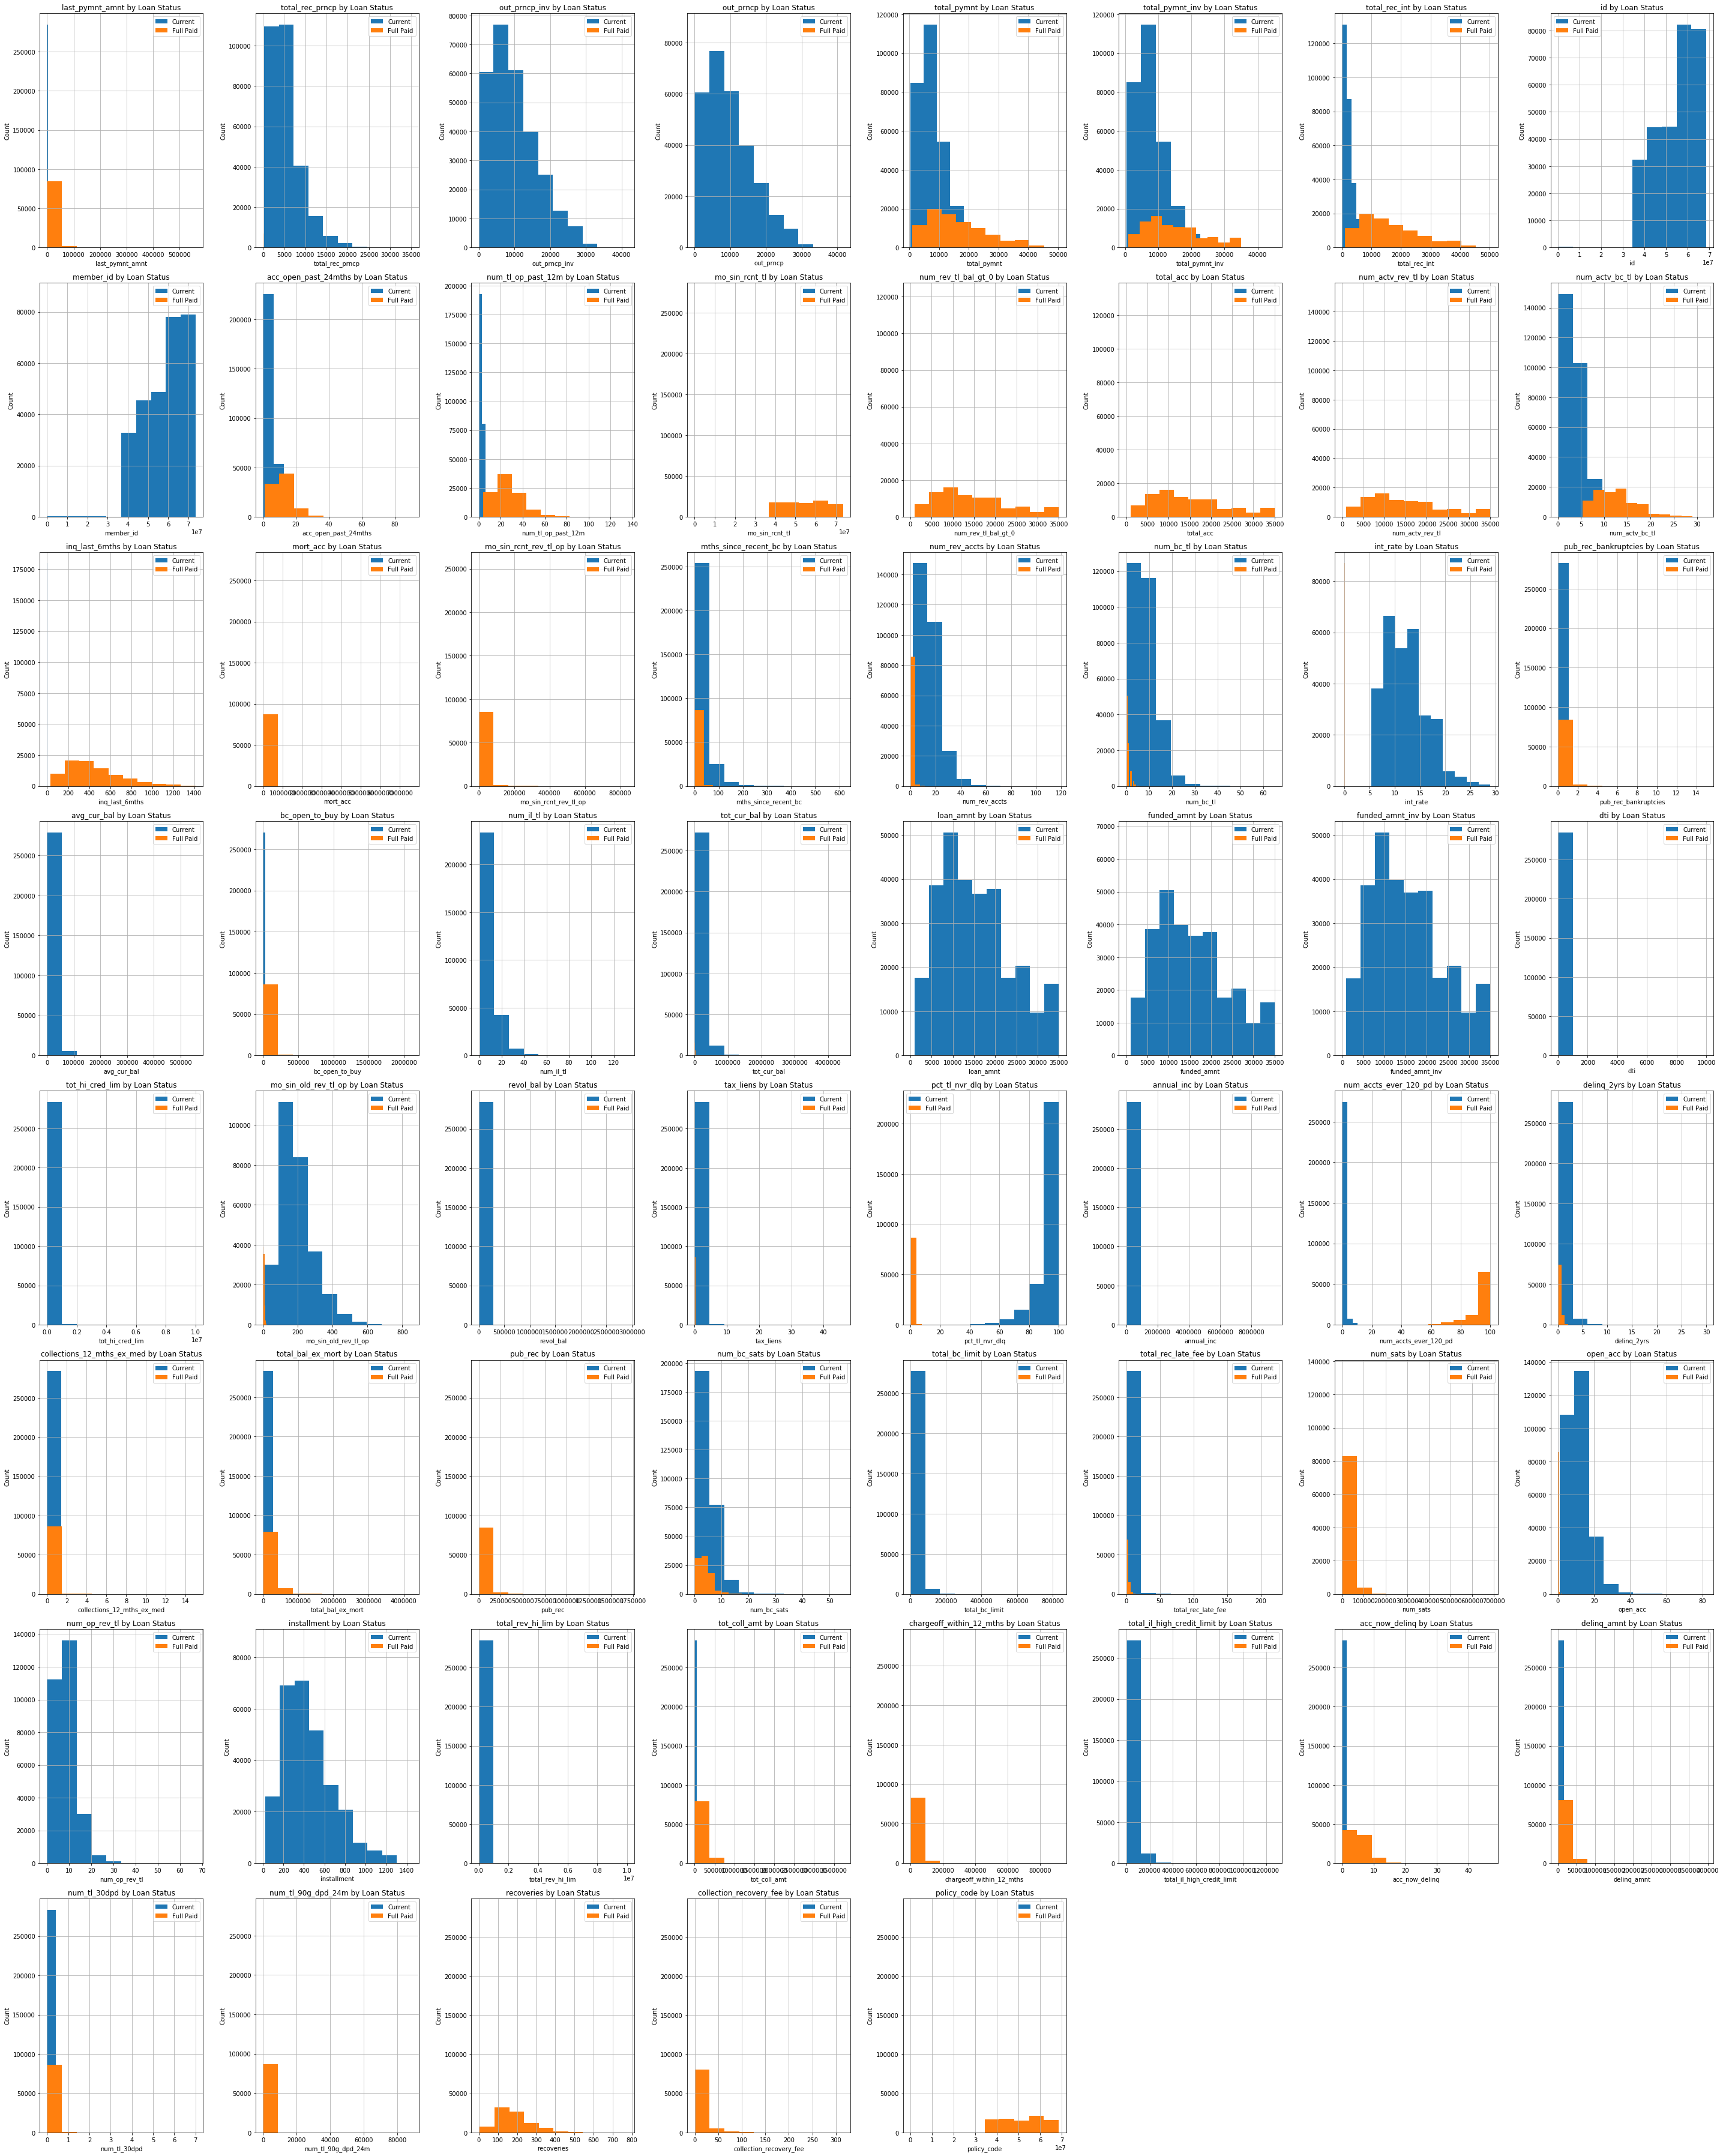

In [73]:
#look at distribution of numeric variables by target variable

var = ['last_pymnt_amnt', 'total_rec_prncp',
       'out_prncp_inv', 'out_prncp', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_int', 'id', 'member_id', 'acc_open_past_24mths',
       'num_tl_op_past_12m', 'mo_sin_rcnt_tl', 'num_rev_tl_bal_gt_0',
       'total_acc', 'num_actv_rev_tl', 'num_actv_bc_tl', 'inq_last_6mths',
       'mort_acc', 'mo_sin_rcnt_rev_tl_op', 'mths_since_recent_bc',
       'num_rev_accts', 'num_bc_tl', 'int_rate', 'pub_rec_bankruptcies',
       'avg_cur_bal', 'bc_open_to_buy', 'num_il_tl', 'tot_cur_bal',
       'loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'dti', 'tot_hi_cred_lim',
       'mo_sin_old_rev_tl_op', 'revol_bal', 'tax_liens', 'pct_tl_nvr_dlq',
       'annual_inc', 'num_accts_ever_120_pd', 'delinq_2yrs',
       'collections_12_mths_ex_med', 'total_bal_ex_mort', 'pub_rec',
       'num_bc_sats', 'total_bc_limit', 'total_rec_late_fee', 'num_sats',
       'open_acc', 'num_op_rev_tl', 'installment', 'total_rev_hi_lim',
       'tot_coll_amt', 'chargeoff_within_12_mths',
       'total_il_high_credit_limit', 'acc_now_delinq', 'delinq_amnt',
       'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'recoveries',
       'collection_recovery_fee', 'policy_code']

plt.figure(figsize=(40,50))

for i in range(len(var)):
    
    plt.subplot(8,8,i+1)

    p1 = current[var[i]].hist(alpha=1.0, label='Current')
    p2 = paid[num[i]].hist(alpha=1.0, label='Full Paid')

    plt.title('{} by Loan Status'.format(var[i]))
    plt.xlabel('{}'.format(var[i]))
    plt.ylabel('Count')
    plt.legend(loc=0)

plt.tight_layout()
plt.show()

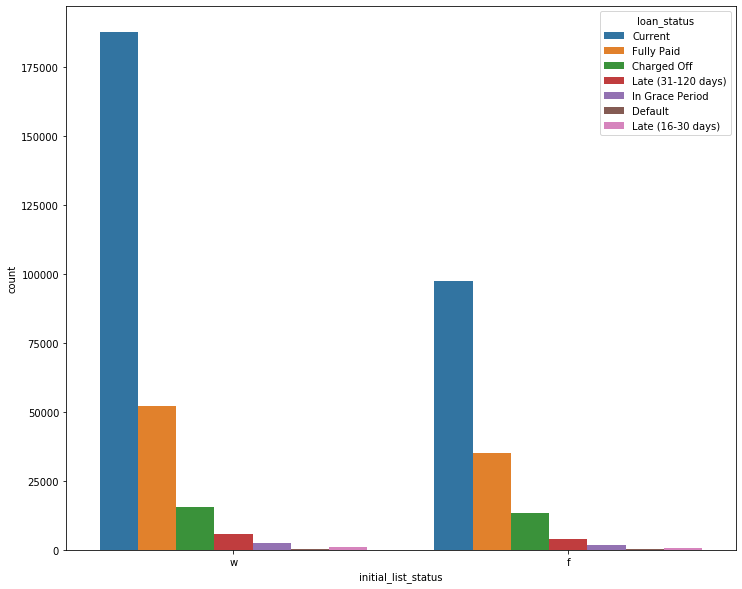

In [27]:
plt.figure(figsize=(12,10))
sns.countplot(x='initial_list_status', hue='loan_status', data=lc)

plt.show()

In [44]:
final = lc[['loan_status','last_pymnt_amnt', 'total_rec_prncp','out_prncp_inv', 
            'out_prncp', 'total_pymnt', 'total_pymnt_inv',
            'title', 'initial_list_status','home_ownership', 
            'term', 'grade', 'verification_status','purpose', 'application_type']]

#try using numeric variables only 

final2 = lc[['loan_status','last_pymnt_amnt', 'total_rec_prncp','out_prncp_inv', 
            'out_prncp', 'total_pymnt', 'total_pymnt_inv']]

final3 = lc[['loan_status','last_pymnt_amnt', 'total_rec_prncp','out_prncp_inv', 
            'out_prncp']]

final4 = lc[['loan_status','last_pymnt_amnt','total_rec_prncp','out_prncp_inv']]

final5 = lc[['loan_status','last_pymnt_amnt','total_rec_prncp']]

final6 = lc[['loan_status','last_pymnt_amnt', 'initial_list_status']]

final7 = lc[['loan_status','out_prncp_inv', 'out_prncp']]

final8 = lc[['loan_status','last_pymnt_amnt', 'out_prncp_inv']]

final9 = lc[['loan_status', 'last_pymnt_amnt']]

final.head()

,loan_status,last_pymnt_amnt,total_rec_prncp,out_prncp_inv,out_prncp,total_pymnt,total_pymnt_inv,title,initial_list_status,home_ownership,term,grade,verification_status,purpose,application_type
0,Current,379.39,2331.12,13668.88,13668.88,4519.68,4519.68,Credit card refinancing,w,MORTGAGE,60 months,C,Not Verified,credit_card,INDIVIDUAL
1,Current,298.58,2964.31,6635.69,6635.69,3572.97,3572.97,Credit card refinancing,w,MORTGAGE,36 months,A,Not Verified,credit_card,INDIVIDUAL
2,Fully Paid,20807.39,25000.00,0.00,0.00,26224.23,26224.23,Debt consolidation,w,MORTGAGE,36 months,A,Not Verified,debt_consolidation,INDIVIDUAL
3,Current,858.05,8736.23,19263.77,19263.77,10271.36,10271.36,Debt consolidation,w,MORTGAGE,36 months,A,Not Verified,debt_consolidation,INDIVIDUAL
4,Fully Paid,8251.42,8650.00,0.00,0.00,9190.49,9190.49,Debt consolidation,w,RENT,36 months,E,Verified,debt_consolidation,INDIVIDUAL


In [85]:
final_data.head()

,loan_status,last_pymnt_amnt,total_rec_prncp,out_prncp_inv,out_prncp,total_pymnt,total_pymnt_inv,title_Car financing,title_Credit Card/Auto Repair,title_Credit card refinancing,...,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_JOINT
0,Current,379.39,2331.12,13668.88,13668.88,4519.68,4519.68,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,Current,298.58,2964.31,6635.69,6635.69,3572.97,3572.97,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,Fully Paid,20807.39,25000.00,0.00,0.00,26224.23,26224.23,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Current,858.05,8736.23,19263.77,19263.77,10271.36,10271.36,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Fully Paid,8251.42,8650.00,0.00,0.00,9190.49,9190.49,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [90]:
#use 6 numeric variables + 8 categorical variables 
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

rfc = ensemble.RandomForestClassifier()
X = final_data.drop('loan_status', 1)
Y = final_data['loan_status']

cv = cross_val_score(rfc, X, Y, cv=10)

print(cv)
print(np.mean(cv))

[0.90862214 0.95977839 0.95666043 0.9541181  0.95210342 0.95298971
 0.94886309 0.95454654 0.95622346 0.95723092]
0.9499505097747363


In [91]:
#use 6 numeric variables only
rfc = ensemble.RandomForestClassifier()
X = final2.drop('loan_status', 1)
Y = final2['loan_status']

cv = cross_val_score(rfc, X, Y, cv=10)

print(cv)
print(np.mean(cv))

[0.79143782 0.96107354 0.9413105  0.95375833 0.9499928  0.9408294
 0.90955099 0.92900146 0.94348629 0.95977356]
0.9280214702288399


In [100]:
#use 4 numeric variables only
rfc = ensemble.RandomForestClassifier()
X = final3.drop('loan_status', 1)
Y = final3['loan_status']

cv = cross_val_score(rfc, X, Y, cv=10)

print(cv)
print(np.mean(cv))

[0.8214654  0.95092819 0.93013383 0.95435794 0.95114405 0.94524261
 0.92082414 0.93233552 0.9431025  0.95576771]
0.9305301884756968


In [105]:
#use 3 numeric variables only
rfc = ensemble.RandomForestClassifier()
X = final4.drop('loan_status', 1)
Y = final4['loan_status']

cv = cross_val_score(rfc, X, Y, cv=10)

print(cv)
print(np.mean(cv))

#undersample to balance the training set

[0.83863773 0.95215139 0.92600854 0.95421404 0.95157577 0.94560238
 0.92420608 0.9369888  0.94969896 0.95586366]
0.9334947334300047


In [107]:
#use 2 numeric variables only
rfc = ensemble.RandomForestClassifier()
X = final5.drop('loan_status', 1)
Y = final5['loan_status']

cv = cross_val_score(rfc, X, Y, cv=10)

print(cv)
print(np.mean(cv))

[0.84580885 0.89806687 0.86964551 0.9190531  0.91593515 0.91120812
 0.88592536 0.90005037 0.91299863 0.91134352]
0.8970035475412674


In [24]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

#use 2 numeric variables only
rfc = ensemble.RandomForestClassifier()
X = final7.drop('loan_status', 1)
Y = final7['loan_status']

cv = cross_val_score(rfc, X, Y, cv=10)

print(cv)
print(np.mean(cv))

[0.85425111 0.86343359 0.85127356 0.87580947 0.87185207 0.86748375
 0.85181809 0.85771509 0.86358512 0.85468589]
0.8611907741381184


In [125]:
cat=['initial_list_status']

final_df = pd.get_dummies(final6, columns=cat, drop_first=True)

final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 416925 entries, 0 to 421094
Data columns (total 3 columns):
loan_status              416925 non-null object
last_pymnt_amnt          416925 non-null float64
initial_list_status_w    416925 non-null uint8
dtypes: float64(1), object(1), uint8(1)
memory usage: 29.9+ MB


In [127]:
#use 1 numeric variable and 1 categorical variable
rfc = ensemble.RandomForestClassifier()
X = finaldf.drop('loan_status', 1)
Y = final_df['loan_status']

cv = cross_val_score(rfc, X, Y, cv=10)

print(cv)
print(np.mean(cv))

[0.8354479  0.84501367 0.86247422 0.85988392 0.86122704 0.85736215
 0.85800633 0.85210237 0.8520473  0.69320444]
0.837676933114496


In [43]:
#use 2 numeric variables
rfc = ensemble.RandomForestClassifier()
X = final8.drop('loan_status', 1)
Y = final8['loan_status']

cv = cross_val_score(rfc, X, Y, cv=10)

print(cv)
print(np.mean(cv))

[0.87655594 0.9356742  0.91368063 0.94200604 0.93869622 0.93327417
 0.91713038 0.92734643 0.93736957 0.93885677]
0.926059035232889


In [ ]:
#use 1 numeric variabl
rfc = ensemble.RandomForestClassifier()
X = final9.drop('loan_status', 1)
Y = final9['loan_status']

cv = cross_val_score(rfc, X, Y, cv=10)

print(cv)
print(np.mean(cv))

As we can see from the results from cross validation, the random forest model using two variables last_pymnt_amnt and out_prncp_inv yields an average of 93% accuracy in a 10-fold cross validation. 